# Robustness Analysis: Adjoint and Toggle-Frame Objectives Subject to Either Multiplicative or Additive Errors

This notebook compares the performance of the adjoint and toggling-frame robustness objectives for multiplicative and additive error terms in the system's Hamiltonian. 

## Imports

In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using NamedTrajectories
using Statistics
using CairoMakie
using Random
using ColorSchemes
using Makie
using Printf

  Activating project at `~/Documents/research/notebooks/src`
   Installed Static ──────────────────── v1.3.0
   Installed MutableArithmetics ──────── v1.6.5
   Installed Libmount_jll ────────────── v2.41.2+0
   Installed CodeTracking ────────────── v2.0.1
   Installed Unitful ─────────────────── v1.25.0
   Installed FFTW ────────────────────── v1.10.0
   Installed DataFrames ──────────────── v1.8.0
   Installed Pango_jll ───────────────── v1.56.4+0
   Installed ADTypes ─────────────────── v1.18.0
   Installed StatsPlots ──────────────── v0.15.8
   Installed LazyArrays ──────────────── v2.6.3
   Installed Symbolics ───────────────── v6.55.0
   Installed Libtiff_jll ─────────────── v4.7.2+0
   Installed Plots ───────────────────── v1.41.1
   Installed EnzymeCore ──────────────── v0.8.14
   Installed MathOptInterface ────────── v1.45.0
   Installed ColorSchemes ────────────── v3.31.0
   Installed Libuuid_jll ─────────────── v2.41.2+0
   Installed IntervalArithmetic ──────── v1.0.0
   Inst

In [2]:
# Problem parameters
T = 20
Δt = 0.2
U_goal = GATES.H
H_drive = [PAULIS.X, PAULIS.Y, PAULIS.Z]
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drive)
# Adjoint
∂ₑHₐ = [PAULIS.X, PAULIS.Y, PAULIS.Z]
varsys = VariationalQuantumSystem(
    H_drive,
    ∂ₑHₐ
)


VariationalQuantumSystem: levels = 2, n_drives = 3

Setup metrics

In [3]:
function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * H_err * U
        first_order_terms[i] = first_order_integral
    end
    d = size(U_goal)[1]
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Y * first_order_terms[t] / (d * T))),
                    real(tr(PAULIS.Z * first_order_terms[t] / (d * T)))] for t in 1:T] 
    return space_curve
end

function space_curve_robustness(traj::NamedTrajectory, U_goal::AbstractMatrix, H_err::AbstractMatrix)
    curve = SpaceCurve(traj, U_goal, H_err)
    # Use the norm of the final point as a robustness measure
    # (larger values indicate more accumulated error sensitivity)
    final_point = curve[end]
    return norm(final_point)
end

function width_robustness(system::AbstractQuantumSystem, traj::NamedTrajectory; thresh::Float64=0.999)
    F = 1.0
    drift = system.H.H_drift
    drive = system.H.H_drives
    pauls = [PAULIS.X, PAULIS.Y, PAULIS.Z]
    widths = []
    for i in 1:3
        ε = 0.0
        err = pauls[i]
        F = 1.0
        while (ε < 0.5 && F >= thresh)
            noisy_drift = drift + ε * err
            noisy_sys = QuantumSystem(noisy_drift, drive)
            F = unitary_rollout_fidelity(traj, noisy_sys)
            ε += 0.0001
        end
        push!(widths, ε)
    end
    return widths
end


width_robustness (generic function with 1 method)

In [4]:
# Define parameter ranges (logarithmic scale)
a_bounds = 10 .^ range(-.5, 0.5, length=10)  # 1e0 to 1e1
dda_bounds = 10 .^ range(-0.5, 0.5, length=25)  # 1e-1 to 1e1

n_seeds = 2  # Number of random seeds to test
n_drives = sys.n_drives
var_n_drives = varsys.n_drives
variational_scales = fill(1.0, length(varsys.G_vars))

println("Parameter ranges:")
println("a_bounds: ", a_bounds)
println("dda_bounds: ", dda_bounds)
println("Number of seeds: ", n_seeds)

# Initialize results storage - now with an extra dimension for seeds
trajectories = Array{Any}(undef, length(a_bounds), length(dda_bounds), n_seeds)
fidelities = zeros(length(a_bounds), length(dda_bounds), n_seeds)
convergence_times = zeros(length(a_bounds), length(dda_bounds), n_seeds)
final_costs = zeros(length(a_bounds), length(dda_bounds), n_seeds)

# Define seeds to use consistently across all parameter combinations
seed_values = [42, 123]

# Parameter sweep
println("\nStarting parameter sweep with multiple seeds...")
for (i, a_bound) in enumerate(a_bounds)
    for (j, dda_bound) in enumerate(dda_bounds)
        println("\n" * "="^60)
        println("Parameter set: a_bound=$(Printf.@sprintf("%.3e", a_bound)), dda_bound=$(Printf.@sprintf("%.3e", dda_bound))")
        println("="^60)
        
        for (seed_idx, seed) in enumerate(seed_values)
            println("\n  Seed $seed_idx (value=$seed):")
            
            # Set random seed for reproducibility
            Random.seed!(seed)
            
            # Create variational problem with current parameters
            var_prob_test = UnitaryVariationalProblem(
                varsys, U_goal, T, Δt;
                robust_times=[[T], [T], [T]],
                a_bound = a_bound,
                dda_bound = dda_bound,
                piccolo_options=piccolo_opts
            )
            
            # Solve with timing
            elapsed_time = @elapsed begin
                solve!(var_prob_test, max_iter=750, print_level=0, 
                        options=IpoptOptions(eval_hessian=false))
                solve!(var_prob_test, max_iter=30, print_level=0)
            end
            
            # Calculate final fidelity
            fidelity = unitary_rollout_fidelity(var_prob_test.trajectory, sys)
            
            # Store results
            trajectories[i, j, seed_idx] = var_prob_test.trajectory
            fidelities[i, j, seed_idx] = fidelity
            convergence_times[i, j, seed_idx] = elapsed_time
            Z_vec = vec(var_prob_test.trajectory)
            final_costs[i, j, seed_idx] = var_prob_test.objective.L(Z_vec)
            
            println("    -> Fidelity: $(Printf.@sprintf("%.6f", fidelity)), Time: $(Printf.@sprintf("%.2f", elapsed_time))s, Cost: $(Printf.@sprintf("%.4e", final_costs[i, j, seed_idx]))")
        end
        
        # Compare seeds for this parameter combination
        fid_diff = abs(fidelities[i, j, 1] - fidelities[i, j, 2])
        println("\n  Seed comparison:")
        println("    Fidelity difference: $(Printf.@sprintf("%.6f", fid_diff))")
        println("    Best seed: $(fidelities[i, j, 1] >= fidelities[i, j, 2] ? "Seed 1" : "Seed 2")")
    end
end

# Compute statistics across seeds
mean_fidelities = mean(fidelities, dims=3)[:, :, 1]
std_fidelities = std(fidelities, dims=3)[:, :, 1]
max_fidelities = maximum(fidelities, dims=3)[:, :, 1]
min_fidelities = minimum(fidelities, dims=3)[:, :, 1]

mean_times = mean(convergence_times, dims=3)[:, :, 1]
mean_costs = mean(final_costs, dims=3)[:, :, 1]

println("\n" * "="^80)
println("MULTI-SEED ANALYSIS COMPLETE")
println("="^80)
println("\nFidelity statistics across seeds:")
println("  Mean of means: $(Printf.@sprintf("%.6f", mean(mean_fidelities)))")
println("  Mean of stds: $(Printf.@sprintf("%.6f", mean(std_fidelities)))")
println("  Max std: $(Printf.@sprintf("%.6f", maximum(std_fidelities)))")
println("  Overall best: $(Printf.@sprintf("%.6f", maximum(fidelities)))")
println("  Overall worst: $(Printf.@sprintf("%.6f", minimum(fidelities)))")

Parameter ranges:
a_bounds: [0.31622776601683794, 0.4084238652674521, 0.5274997063702618, 0.6812920690579612, 0.879922543569107, 1.1364636663857248, 1.4677992676220695, 1.8957356524063758, 2.4484367468222272, 3.1622776601683795]
dda_bounds: [0.31622776601683794, 0.3480700588428411, 0.38311868495572876, 0.4216965034285822, 0.4641588833612779, 0.5108969774506927, 0.5623413251903491, 0.6189658188912606, 0.6812920690579612, 0.7498942093324559, 0.8254041852680184, 0.9085175756516868, 1.0, 1.1006941712522096, 1.2115276586285884, 1.333521432163324, 1.4677992676220695, 1.6155980984398741, 1.7782794100389228, 1.9573417814876604, 2.154434690031884, 2.371373705661655, 2.610157215682537, 2.8729848333536645, 3.1622776601683795]
Number of seeds: 2

Starting parameter sweep with multiple seeds...

Parameter set: a_bound=3.162e-01, dda_bound=3.162e-01

  Seed 1 (value=42):
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial val

Excessive output truncated after 524294 bytes.

    -> Fidelity: 0.960424, Time: 75.38s, Cost: 5.8274e+00

  Seed comparison:


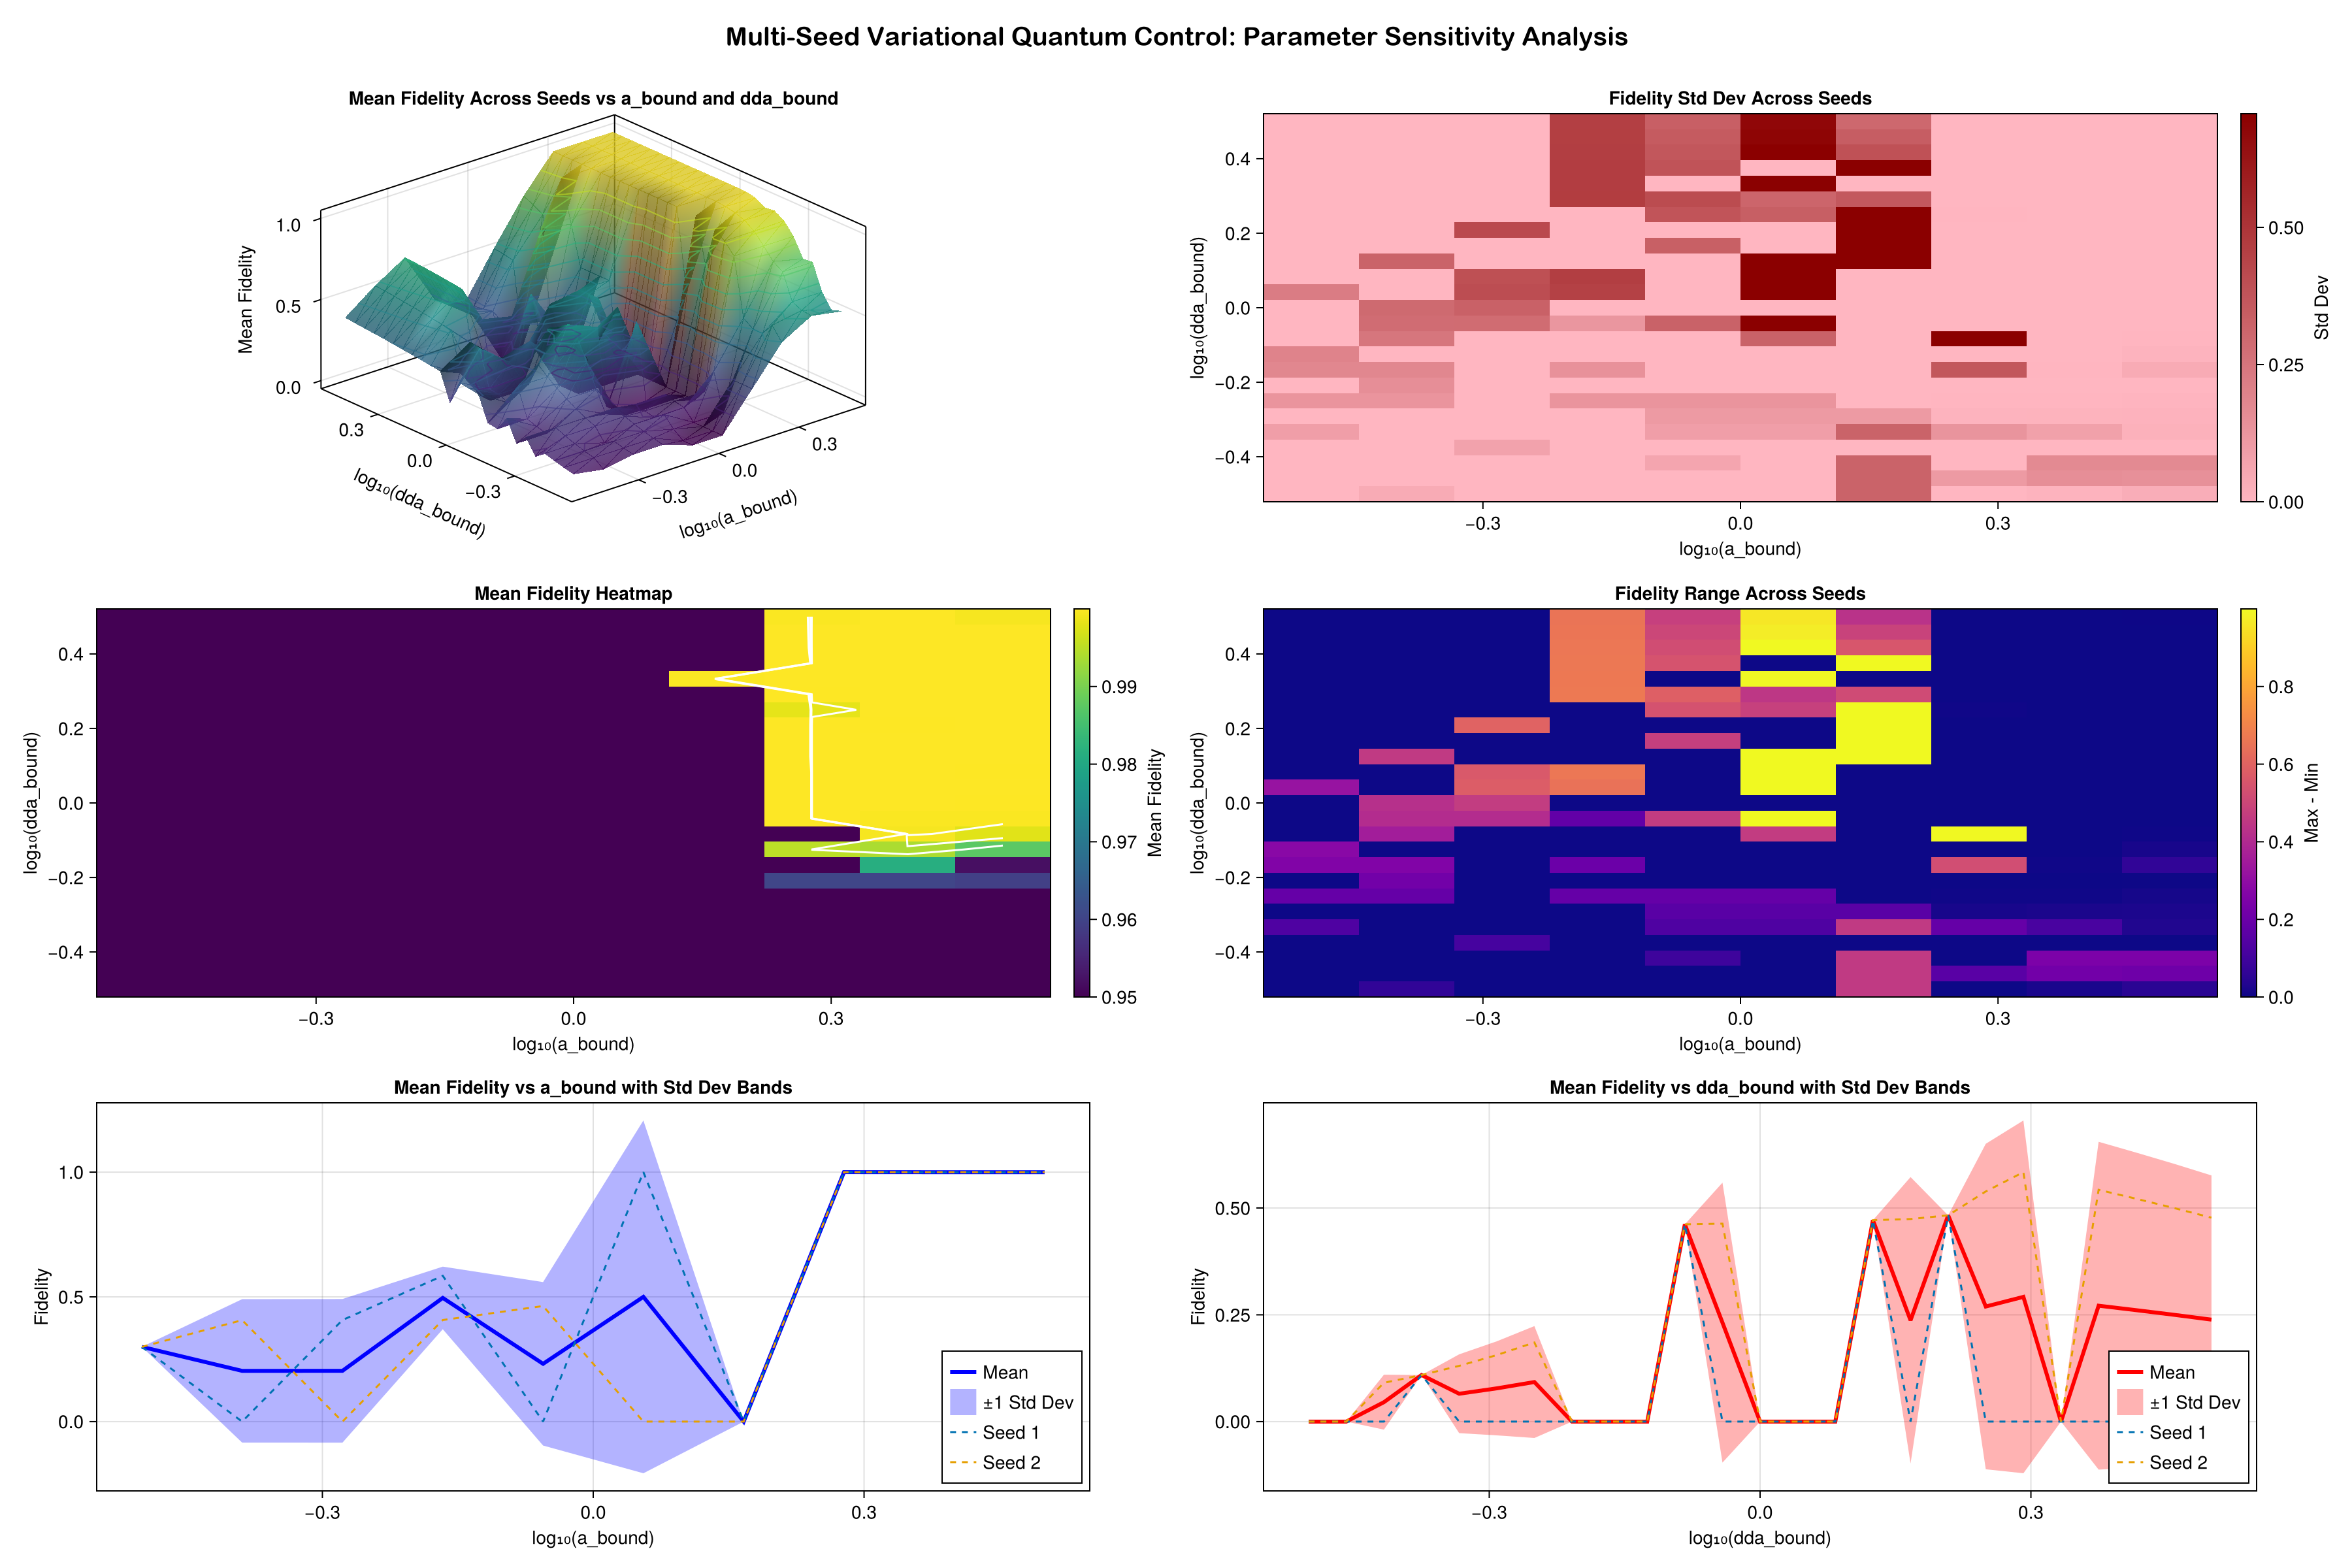

In [5]:
# Create comprehensive visualization with multi-seed analysis
f = Figure(size=(1800, 1200))

# 1. Mean Fidelity 3D Surface Plot
ax3d = Axis3(f[1, 1:2],
    title="Mean Fidelity Across Seeds vs a_bound and dda_bound",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)",
    zlabel="Mean Fidelity",
    aspect=(1, 1, 0.5)
)

# Create meshgrid for 3D plot
x_3d = repeat(log10.(a_bounds), 1, length(dda_bounds))
y_3d = repeat(log10.(dda_bounds)', length(a_bounds), 1)
z_3d = mean_fidelities

# Create 3D surface
Makie.surface!(ax3d, x_3d, y_3d, z_3d, colormap=:viridis, alpha=0.8)
Makie.contour3d!(ax3d, x_3d, y_3d, z_3d, levels=10, linewidth=1, alpha=0.6)

# 2. Mean Fidelity 2D Heatmap
ax_heat_mean = Axis(f[2, 1],
    title="Mean Fidelity Heatmap",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)"
)

hm_mean = Makie.heatmap!(ax_heat_mean, log10.(a_bounds), log10.(dda_bounds), mean_fidelities,
             colormap=:viridis, colorrange=(0.95, 1.0))
Colorbar(f[2, 2], hm_mean, label="Mean Fidelity")

Makie.contour!(ax_heat_mean, log10.(a_bounds), log10.(dda_bounds), mean_fidelities,
        levels=[0.99, 0.995, 0.999], color=:white, linewidth=1.5)

# 3. Standard Deviation Heatmap (shows seed variability)
ax_heat_std = Axis(f[1, 3],
    title="Fidelity Std Dev Across Seeds",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)"
)

hm_std = Makie.heatmap!(ax_heat_std, log10.(a_bounds), log10.(dda_bounds), std_fidelities,
             colormap=:reds)
Colorbar(f[1, 4], hm_std, label="Std Dev")

# 4. Max-Min Difference (shows range across seeds)
fidelity_range = max_fidelities - min_fidelities
ax_heat_range = Axis(f[2, 3],
    title="Fidelity Range Across Seeds",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)"
)

hm_range = Makie.heatmap!(ax_heat_range, log10.(a_bounds), log10.(dda_bounds), fidelity_range,
             colormap=:plasma)
Colorbar(f[2, 4], hm_range, label="Max - Min")

# 5. Cross-section comparison showing variability
ax_cross1 = Axis(f[3, 1:2],
    title="Mean Fidelity vs a_bound with Std Dev Bands",
    xlabel="log₁₀(a_bound)",
    ylabel="Fidelity"
)

# Select middle dda_bound for cross-section
mid_dda_idx = round(Int, length(dda_bounds)/2)

# Plot mean with error bands
lines!(ax_cross1, log10.(a_bounds), mean_fidelities[:, mid_dda_idx],
       label="Mean", color=:blue, linewidth=3)
band!(ax_cross1, log10.(a_bounds),
      mean_fidelities[:, mid_dda_idx] .- std_fidelities[:, mid_dda_idx],
      mean_fidelities[:, mid_dda_idx] .+ std_fidelities[:, mid_dda_idx],
      color=(:blue, 0.3), label="±1 Std Dev")

# Plot individual seeds
for seed_idx in 1:n_seeds
    lines!(ax_cross1, log10.(a_bounds), fidelities[:, mid_dda_idx, seed_idx],
           label="Seed $seed_idx", linewidth=1.5, linestyle=:dash)
end

axislegend(ax_cross1, position=:rb)

# 6. Cross-section for dda_bound
ax_cross2 = Axis(f[3, 3:4],
    title="Mean Fidelity vs dda_bound with Std Dev Bands",
    xlabel="log₁₀(dda_bound)",
    ylabel="Fidelity"
)

# Select middle a_bound for cross-section
mid_a_idx = round(Int, length(a_bounds)/2)

lines!(ax_cross2, log10.(dda_bounds), mean_fidelities[mid_a_idx, :],
       label="Mean", color=:red, linewidth=3)
band!(ax_cross2, log10.(dda_bounds),
      mean_fidelities[mid_a_idx, :] .- std_fidelities[mid_a_idx, :],
      mean_fidelities[mid_a_idx, :] .+ std_fidelities[mid_a_idx, :],
      color=(:red, 0.3), label="±1 Std Dev")

# Plot individual seeds
for seed_idx in 1:n_seeds
    lines!(ax_cross2, log10.(dda_bounds), fidelities[mid_a_idx, :, seed_idx],
           label="Seed $seed_idx", linewidth=1.5, linestyle=:dash)
end

axislegend(ax_cross2, position=:rb)

# Add overall title
Label(f[0, 1:4], "Multi-Seed Variational Quantum Control: Parameter Sensitivity Analysis",
      fontsize=20, font="bold")

# Display the figure
display(f)

# Print summary statistics
println("\n" * "="^60)
println("SUMMARY STATISTICS (MULTI-SEED)")
println("="^60)

max_mean_fidelity = maximum(mean_fidelities)
max_idx = argmax(mean_fidelities)
best_a = a_bounds[max_idx[1]]
best_dda = dda_bounds[max_idx[2]]

println("\nBest mean fidelity: $(Printf.@sprintf("%.6f", max_mean_fidelity))")
println("Best parameters: a_bound = $(Printf.@sprintf("%.3e", best_a)), dda_bound = $(Printf.@sprintf("%.3e", best_dda))")
println("Std dev at best params: $(Printf.@sprintf("%.6f", std_fidelities[max_idx]))")
println("Range at best params: $(Printf.@sprintf("%.6f", fidelity_range[max_idx]))")

# Find parameters with both high mean and low variance
high_quality_mask = (mean_fidelities .> 0.999) .& (std_fidelities .< 0.001)
n_high_quality = sum(high_quality_mask)
println("\nParameter combinations with fidelity > 0.999 AND std < 0.001: $n_high_quality / $(length(mean_fidelities))")

# Identify most stable parameter regions (low variance)
min_std = minimum(std_fidelities)
min_std_idx = argmin(std_fidelities)
println("\nMost stable parameters (lowest std dev):")
println("  a_bound = $(Printf.@sprintf("%.3e", a_bounds[min_std_idx[1]])), dda_bound = $(Printf.@sprintf("%.3e", dda_bounds[min_std_idx[2]]))")
println("  Std dev: $(Printf.@sprintf("%.6f", min_std))")
println("  Mean fidelity: $(Printf.@sprintf("%.6f", mean_fidelities[min_std_idx]))")

# Seed sensitivity analysis
avg_std = mean(std_fidelities)
max_std = maximum(std_fidelities)
max_std_idx = argmax(std_fidelities)
println("\nSeed sensitivity across all parameters:")
println("  Average std dev: $(Printf.@sprintf("%.6f", avg_std))")
println("  Maximum std dev: $(Printf.@sprintf("%.6f", max_std))")
println("  Most sensitive at: a_bound = $(Printf.@sprintf("%.3e", a_bounds[max_std_idx[1]])), dda_bound = $(Printf.@sprintf("%.3e", dda_bounds[max_std_idx[2]]))")

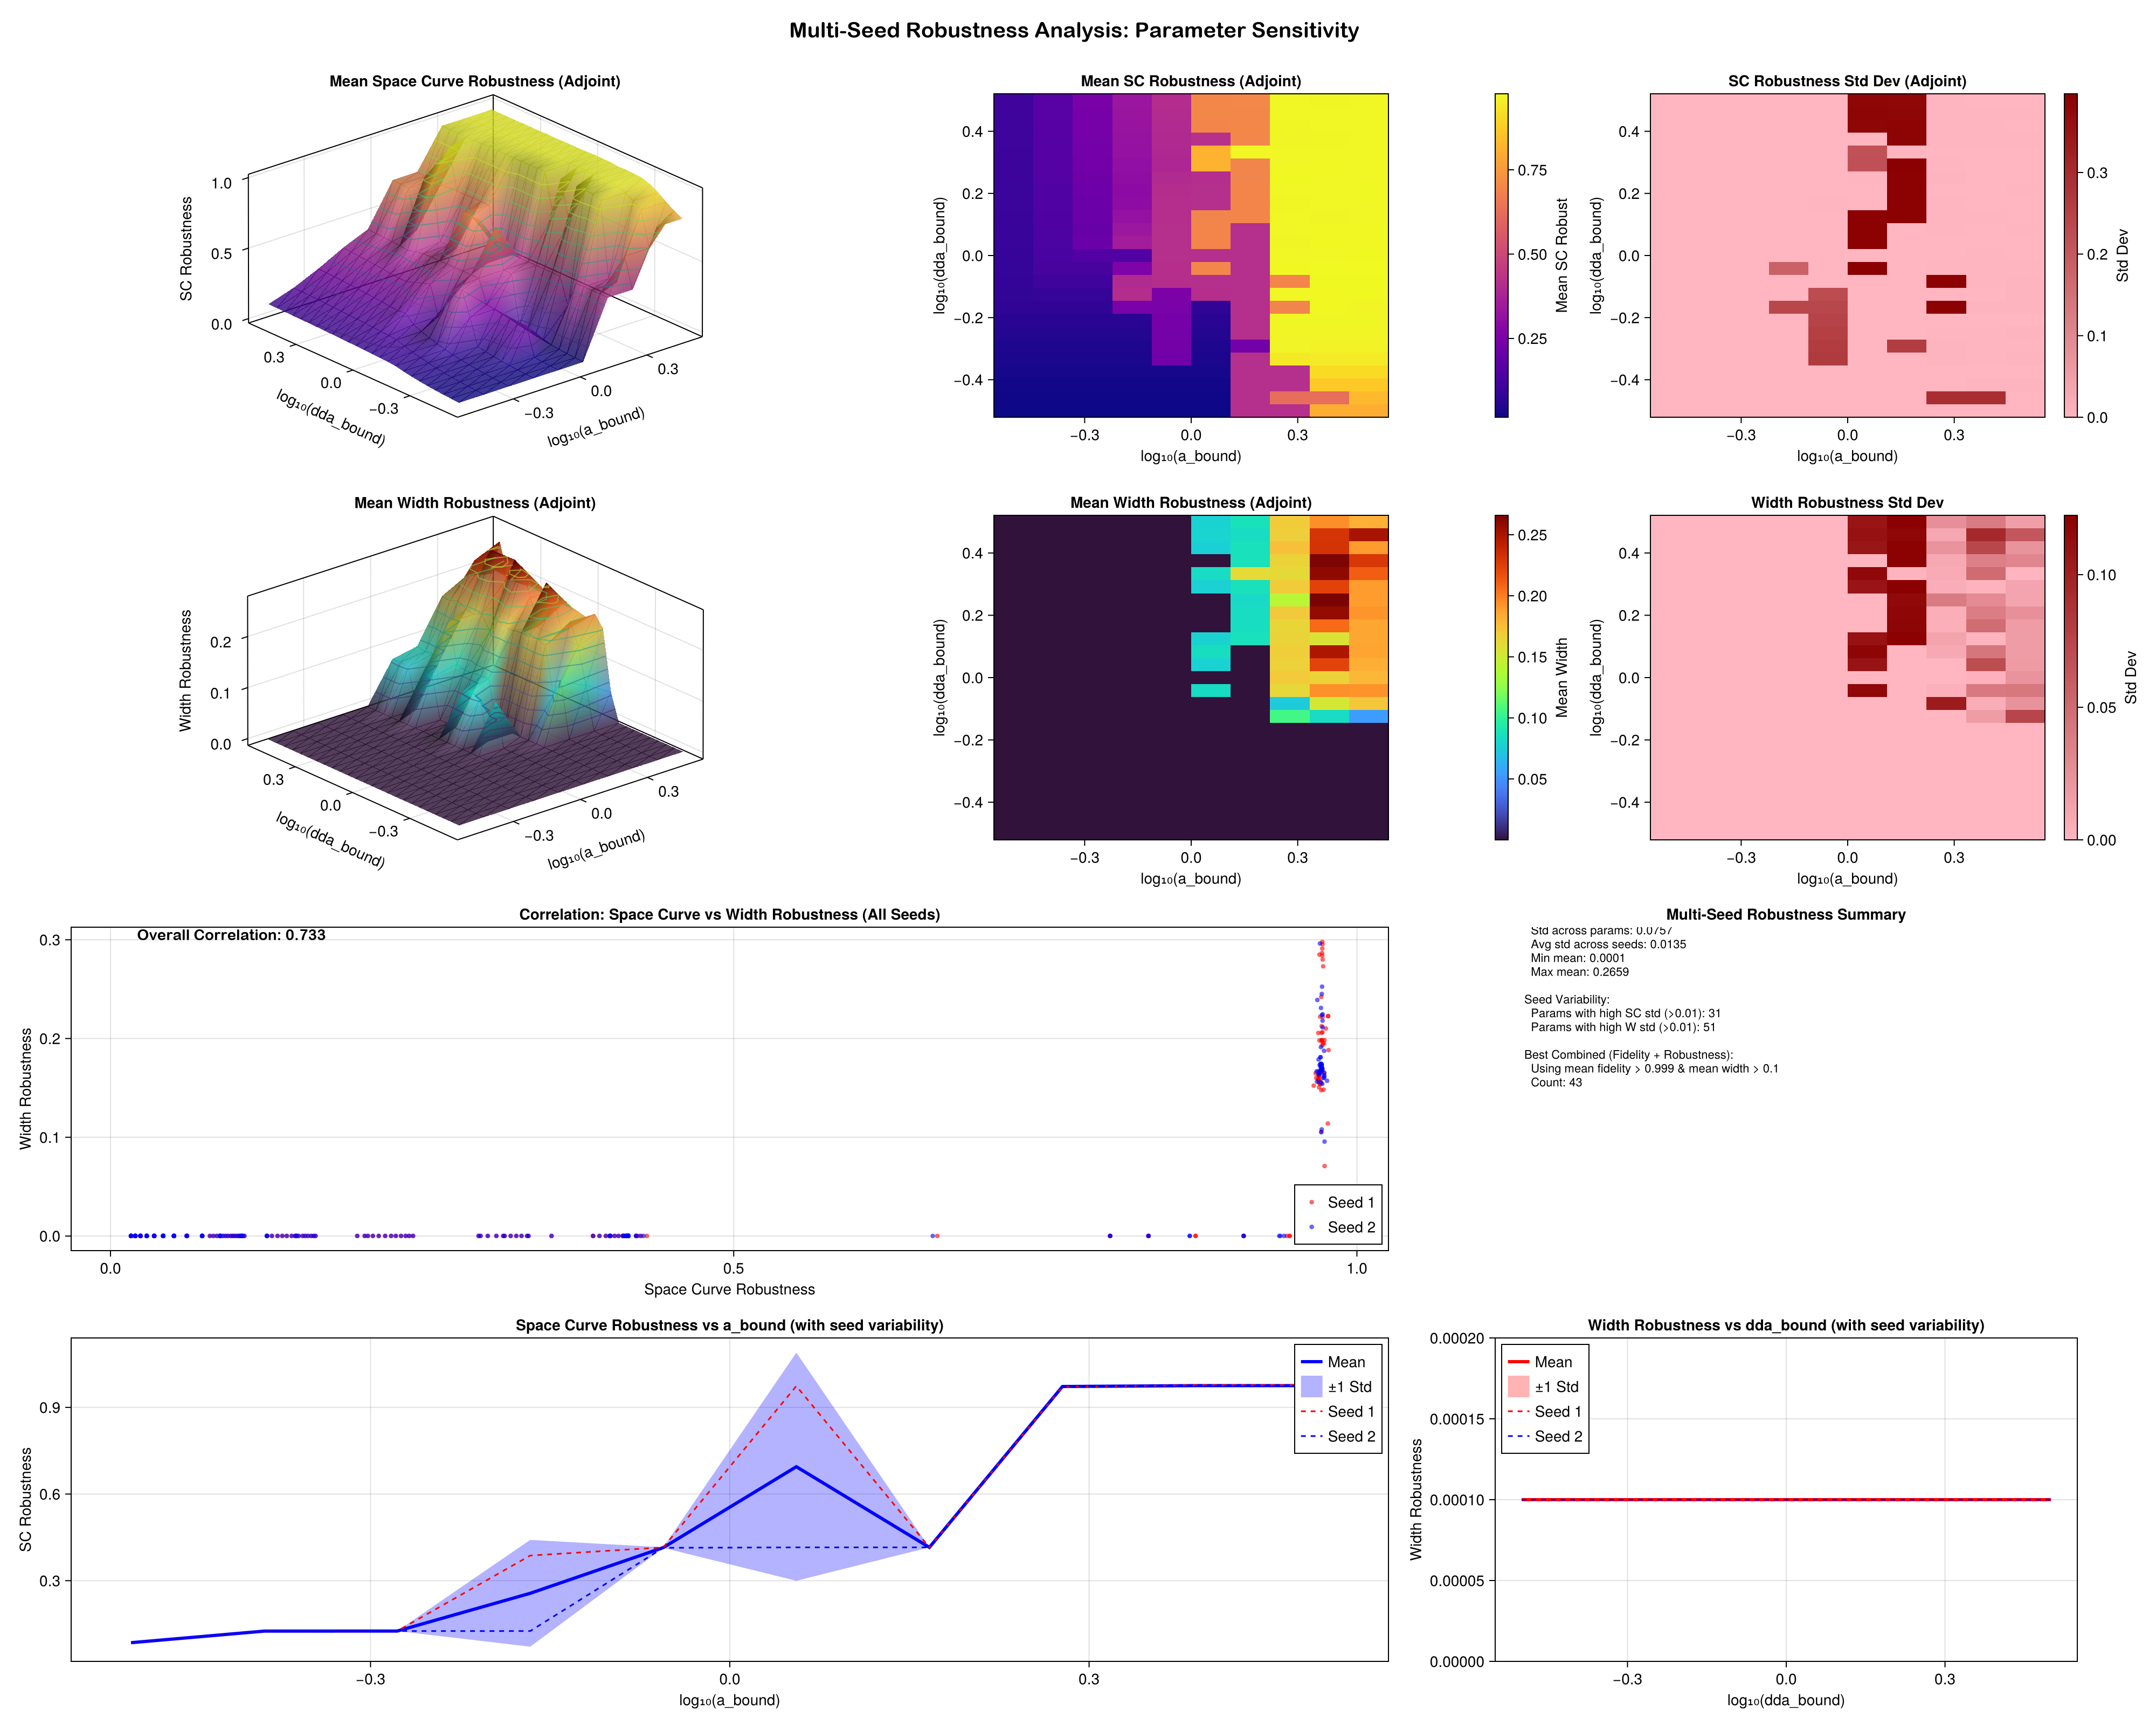

In [6]:
# Calculate robustness metrics for all trajectories (all seeds)
println("\nCalculating robustness metrics for all seeds...")

# Initialize storage for robustness metrics (now with seed dimension)
space_curve_robustness_values = zeros(length(a_bounds), length(dda_bounds), n_seeds)
width_robustness_x = zeros(length(a_bounds), length(dda_bounds), n_seeds)
width_robustness_y = zeros(length(a_bounds), length(dda_bounds), n_seeds)
width_robustness_z = zeros(length(a_bounds), length(dda_bounds), n_seeds)
width_robustness_avg = zeros(length(a_bounds), length(dda_bounds), n_seeds)

# Calculate robustness for each trajectory
for (i, a_bound) in enumerate(a_bounds)
    for (j, dda_bound) in enumerate(dda_bounds)
        for seed_idx in 1:n_seeds
            if !isnothing(trajectories[i, j, seed_idx])
                traj = trajectories[i, j, seed_idx]
                
                # Space curve robustness (average over all Pauli errors)
                Xerr = space_curve_robustness(traj, U_goal, PAULIS.X)
                Yerr = space_curve_robustness(traj, U_goal, PAULIS.Y)
                Zerr = space_curve_robustness(traj, U_goal, PAULIS.Z)
                space_curve_robustness_values[i, j, seed_idx] = 1-(Xerr + Yerr + Zerr) / 3
                
                # Width robustness
                widths = width_robustness(sys, traj, thresh=0.99)
                width_robustness_x[i, j, seed_idx] = widths[1]
                width_robustness_y[i, j, seed_idx] = widths[2]
                width_robustness_z[i, j, seed_idx] = widths[3]
                width_robustness_avg[i, j, seed_idx] = mean(widths)
                
                println("a=$(Printf.@sprintf("%.3e", a_bound)), dda=$(Printf.@sprintf("%.3e", dda_bound)), seed=$seed_idx: " *
                       "SC_robust=$(Printf.@sprintf("%.4f", space_curve_robustness_values[i, j, seed_idx])), " *
                       "Width_avg=$(Printf.@sprintf("%.4f", width_robustness_avg[i, j, seed_idx]))")
            end
        end
    end
end

# Compute statistics across seeds for robustness metrics
mean_sc_robust = mean(space_curve_robustness_values, dims=3)[:, :, 1]
std_sc_robust = std(space_curve_robustness_values, dims=3)[:, :, 1]
mean_width_robust = mean(width_robustness_avg, dims=3)[:, :, 1]
std_width_robust = std(width_robustness_avg, dims=3)[:, :, 1]

# Create comprehensive robustness visualization
f_robust = Figure(size=(2000, 1600))

# Row 1: Mean Space Curve Robustness
ax_sc_3d = Axis3(f_robust[1, 1:2],
    title="Mean Space Curve Robustness (Adjoint)",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)",
    zlabel="SC Robustness",
    aspect=(1, 1, 0.5)
)

x_3d = repeat(log10.(a_bounds), 1, length(dda_bounds))
y_3d = repeat(log10.(dda_bounds)', length(a_bounds), 1)
Makie.surface!(ax_sc_3d, x_3d, y_3d, mean_sc_robust, colormap=:plasma, alpha=0.8)
Makie.contour3d!(ax_sc_3d, x_3d, y_3d, mean_sc_robust, levels=10, linewidth=1, alpha=0.6)

ax_sc_heat = Axis(f_robust[1, 3],
    title="Mean SC Robustness (Adjoint)",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)"
)
hm_sc = Makie.heatmap!(ax_sc_heat, log10.(a_bounds), log10.(dda_bounds), mean_sc_robust, colormap=:plasma)
Colorbar(f_robust[1, 4], hm_sc, label="Mean SC Robust")

ax_sc_std = Axis(f_robust[1, 5],
    title="SC Robustness Std Dev (Adjoint)",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)"
)
hm_sc_std = Makie.heatmap!(ax_sc_std, log10.(a_bounds), log10.(dda_bounds), std_sc_robust, colormap=:reds)
Colorbar(f_robust[1, 6], hm_sc_std, label="Std Dev")

# Row 2: Mean Width Robustness
ax_w_3d = Axis3(f_robust[2, 1:2],
    title="Mean Width Robustness (Adjoint)",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)",
    zlabel="Width Robustness",
    aspect=(1, 1, 0.5)
)

Makie.surface!(ax_w_3d, x_3d, y_3d, mean_width_robust, colormap=:turbo, alpha=0.8)
Makie.contour3d!(ax_w_3d, x_3d, y_3d, mean_width_robust, levels=10, linewidth=1, alpha=0.6)

ax_w_heat = Axis(f_robust[2, 3],
    title="Mean Width Robustness (Adjoint)",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)"
)
hm_w = Makie.heatmap!(ax_w_heat, log10.(a_bounds), log10.(dda_bounds), mean_width_robust, colormap=:turbo)
Colorbar(f_robust[2, 4], hm_w, label="Mean Width")

ax_w_std = Axis(f_robust[2, 5],
    title="Width Robustness Std Dev",
    xlabel="log₁₀(a_bound)",
    ylabel="log₁₀(dda_bound)"
)
hm_w_std = Makie.heatmap!(ax_w_std, log10.(a_bounds), log10.(dda_bounds), std_width_robust, colormap=:reds)
Colorbar(f_robust[2, 6], hm_w_std, label="Std Dev")

# Row 3: Correlation analysis
ax_corr = Axis(f_robust[3, 1:3],
    title="Correlation: Space Curve vs Width Robustness (All Seeds)",
    xlabel="Space Curve Robustness",
    ylabel="Width Robustness"
)

# Flatten all seeds for correlation plot
sc_all = vec(space_curve_robustness_values)
w_all = vec(width_robustness_avg)
fid_all = vec(fidelities)

# Create scatter with seed coloring
colors_seeds = [:red, :blue, :green, :orange, :purple]
for seed_idx in 1:n_seeds
    sc_seed = vec(space_curve_robustness_values[:, :, seed_idx])
    w_seed = vec(width_robustness_avg[:, :, seed_idx])
    Makie.scatter!(ax_corr, sc_seed, w_seed,
              label="Seed $seed_idx",
              color=colors_seeds[seed_idx],
              markersize=6, alpha=0.6)
end

correlation = cor(sc_all, w_all)
text!(ax_corr, 0.05, 0.95, text="Overall Correlation: $(Printf.@sprintf("%.3f", correlation))",
      space=:relative, fontsize=14, font="bold")
axislegend(ax_corr, position=:rb)

# Row 3: Summary statistics
ax_summary = Axis(f_robust[3, 4:6],
    title="Multi-Seed Robustness Summary"
)
hidedecorations!(ax_summary)
hidespines!(ax_summary)

summary_text = """
Space Curve Robustness:
  Mean across all: $(Printf.@sprintf("%.4f", mean(mean_sc_robust)))
  Std across params: $(Printf.@sprintf("%.4f", std(mean_sc_robust)))
  Avg std across seeds: $(Printf.@sprintf("%.4f", mean(std_sc_robust)))
  Min mean: $(Printf.@sprintf("%.4f", minimum(mean_sc_robust)))
  Max mean: $(Printf.@sprintf("%.4f", maximum(mean_sc_robust)))

Width Robustness:
  Mean across all: $(Printf.@sprintf("%.4f", mean(mean_width_robust)))
  Std across params: $(Printf.@sprintf("%.4f", std(mean_width_robust)))
  Avg std across seeds: $(Printf.@sprintf("%.4f", mean(std_width_robust)))
  Min mean: $(Printf.@sprintf("%.4f", minimum(mean_width_robust)))
  Max mean: $(Printf.@sprintf("%.4f", maximum(mean_width_robust)))

Seed Variability:
  Params with high SC std (>0.01): $(sum(std_sc_robust .> 0.01))
  Params with high W std (>0.01): $(sum(std_width_robust .> 0.01))

Best Combined (Fidelity + Robustness):
  Using mean fidelity > 0.999 & mean width > 0.1
  Count: $(sum((mean_fidelities .> 0.999) .& (mean_width_robust .> 0.1)))
"""

text!(ax_summary, 0.05, 0.5, text=summary_text,
      space=:relative, fontsize=11, font="monospace")

# Row 4: Cross-sections with seed bands
mid_dda = round(Int, length(dda_bounds)/2)
mid_a = round(Int, length(a_bounds)/2)

ax_cross_sc = Axis(f_robust[4, 1:3],
    title="Space Curve Robustness vs a_bound (with seed variability)",
    xlabel="log₁₀(a_bound)",
    ylabel="SC Robustness"
)

lines!(ax_cross_sc, log10.(a_bounds), mean_sc_robust[:, mid_dda],
       label="Mean", color=:blue, linewidth=3)
band!(ax_cross_sc, log10.(a_bounds),
      mean_sc_robust[:, mid_dda] .- std_sc_robust[:, mid_dda],
      mean_sc_robust[:, mid_dda] .+ std_sc_robust[:, mid_dda],
      color=(:blue, 0.3), label="±1 Std")

for seed_idx in 1:n_seeds
    lines!(ax_cross_sc, log10.(a_bounds), space_curve_robustness_values[:, mid_dda, seed_idx],
           label="Seed $seed_idx", linewidth=1.5, linestyle=:dash, color=colors_seeds[seed_idx])
end
axislegend(ax_cross_sc, position=:rt)

ax_cross_w = Axis(f_robust[4, 4:6],
    title="Width Robustness vs dda_bound (with seed variability)",
    xlabel="log₁₀(dda_bound)",
    ylabel="Width Robustness"
)

lines!(ax_cross_w, log10.(dda_bounds), mean_width_robust[mid_a, :],
       label="Mean", color=:red, linewidth=3)
band!(ax_cross_w, log10.(dda_bounds),
      mean_width_robust[mid_a, :] .- std_width_robust[mid_a, :],
      mean_width_robust[mid_a, :] .+ std_width_robust[mid_a, :],
      color=(:red, 0.3), label="±1 Std")

for seed_idx in 1:n_seeds
    lines!(ax_cross_w, log10.(dda_bounds), width_robustness_avg[mid_a, :, seed_idx],
           label="Seed $seed_idx", linewidth=1.5, linestyle=:dash, color=colors_seeds[seed_idx])
end
axislegend(ax_cross_w, position=:lt)

Label(f_robust[0, :], "Multi-Seed Robustness Analysis: Parameter Sensitivity",
      fontsize=20, font="bold")

display(f_robust)

println("\nMulti-seed robustness analysis complete!")